# Hyperparameter Optimization For Ridge Regression Model

In [8]:
import numpy as np
import scipy.optimize as opt
import scipy as sci
import matplotlib.pyplot as plt
from functools import *

import sys
sys.path.append("../")
from ddn.node import *

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [9]:
class RidgeNode(AbstractDeclarativeNode):
    
    def __init__(self, n, K, A_train_splitted, b_train_splitted, I_out):
        super().__init__(1, n)
        self.K = K
        self.A_train_splitted = A_train_splitted
        self.b_train_splitted = b_train_splitted
        self.I_out = I_out

    # x is miu
    # y is [beta_1^T,beta_2^T,...,beta_K^T]
    def objective(self, x, y):
        sum = 0
        for i in range(self.K):
            sum += 0.5 * np.sum(np.square(np.dot(self.A_train_splitted[i],y[i])-self.b_train_splitted[i])) + 0.5 * x * np.linalg.norm(y[i],ord = 2)
        return sum

    def solve(self, x):
        result = np.array([])
        for i in range(self.K):
            if i == 0:
                result = sci.linalg.solve(np.dot(self.A_train_splitted[i].T,self.A_train_splitted[i]) + x * self.I_out, np.dot(self.A_train_splitted[i].T, self.b_train_splitted[i]))
            else:
                result = np.vstack((result, sci.linalg.solve(np.dot(self.A_train_splitted[i].T,self.A_train_splitted[i]) + x * self.I_out, np.dot(self.A_train_splitted[i].T,self.b_train_splitted[i]))))
            # print(result.shape)
        return result, None

    def gradient(self, x, y=None, ctx=None):
        if y is None:
            y, ctx = self.solve(x)

        result = np.array([])
        for i in range(self.K):
            if i == 0:
                result = (-1) * sci.linalg.solve(np.dot(self.A_train_splitted[i].T,self.A_train_splitted[i]) + x * self.I_out, y[i])
            else:
                result = np.vstack((result, (-1) * sci.linalg.solve(np.dot(self.A_train_splitted[i].T,self.A_train_splitted[i]) + x * self.I_out, y[i])))
            # print(result.shape)

        return result

In [10]:
class ParameterOptimizer:

    def __init__(self, step_size, tol, max_iters, dataset, K):
        self.step_size = step_size
        self.tol = tol
        self.max_iters = max_iters
        self.A = dataset.data
        self.b = dataset.target
        scaler = StandardScaler()
        A_scaled = scaler.fit_transform(self.A)

        # K-fold
        self.K = 5
        KF = KFold(n_splits = self.K)

        self.A_train_splitted = []
        self.A_test_splitted = []
        self.b_train_splitted = []
        self.b_test_splitted = []

        for train_index, test_index in KF.split(A_scaled):
            A_train, A_test = A_scaled[train_index], A_scaled[test_index]
            self.A_train_splitted.append(A_train)
            self.A_test_splitted.append(A_test)
            b_train, b_test = self.b[train_index], self.b[test_index]
            self.b_train_splitted.append(b_train)
            self.b_test_splitted.append(b_test)
            # print("X_train: ", A_train.shape)
            # print("X_test: ", A_test.shape)

        self.out = self.A_train_splitted[0].shape[1]
        self.I_out = np.eye(self.out)

    def function_objective(self, y):
        sum = 0
        for i in range(self.K):
            y_k = y[i]
            sum += (0.5) * np.sum(np.square(np.dot(self.A_test_splitted[i], y_k) - self.b_test_splitted[i]))
        return sum

    def derivative_objective_y(self, y):
        result = np.array([])
        for i in range(self.K):
            if i == 0:
                result = np.dot((np.dot(y[i].T, self.A_test_splitted[i].T) - self.b_test_splitted[i].T), self.A_test_splitted[i])
            else:
                result = np.vstack((result, np.dot((np.dot(y[i].T, self.A_test_splitted[i].T) - self.b_test_splitted[i].T), self.A_test_splitted[i])))
            # print(result.shape)
        return result

    def simpleGradientDescent(self, node, miu_init, verbose=False):
        cnt = 0
        miu = miu_init
        all_miu = []
        gradient = []
        axis_x = []
        history = []
        loss = []
        print("Start Iteration")
        for i in range(self.max_iters):
            # solve the lower-level problem and compute the upper-level objective
            y, _ = node.solve(miu)
            history.append(self.function_objective(y))
            if verbose: print("{:5d}: {}".format(i, history[-1]))
            if (len(history) > 2) and (history[-2] - history[-1]) < self.tol:
                print("End Iteration")
                print("Weight = {}".format(y))

                break

            # print(derivative_objective_y(y, A_test_splitted, b_test_splitted).shape)
            # compute the gradient of the upper-level objective with respect to x via the chain rule
            dJdx = 0
            for j in range(self.K):
                dJdx += np.dot((self.derivative_objective_y(y)[j]).T, node.gradient(miu, y)[j])

            # take a step in the negative gradient direction
            miu -= self.step_size * dJdx
            all_miu.append(miu)
            gradient.append(abs(dJdx))
            cnt += 1
            axis_x.append(cnt)
            loss.append(self.function_objective(y) / (self.K * self.A_test_splitted[0].shape[0] * 15000))
            if cnt % 10000 == 0:
                print("Iteration time = {} x 5w".format(cnt / 10000))
                print("Hyperparameter = {}".format(miu))
                print("Loss = {}".format(loss[-1]))
                print("Gradient = {}".format(gradient[-1]))


        plt.figure(1)
        plt.plot(axis_x, all_miu)
        plt.xlabel("iteration time")
        plt.ylabel("hyperparameter")

        plt.figure(2)
        plt.plot(all_miu, gradient)
        plt.xlabel("hyperparameter")
        plt.ylabel("abs(gradient)")
        plt.axhline(y=0, color='r', linestyle = '--')
        # print(gradient[-1])

        plt.figure(3)
        plt.plot(all_miu, loss)
        plt.xlabel("hyperparameter")
        plt.ylabel("loss function")
        # print(loss[-1])

        print("Iteration time: ", cnt)
        print("Loss = {}".format(loss[-1]))
        print("Gradient = {}".format(gradient[-1]))
        return miu, history

In [11]:
def solve_problem():
    optimizer = ParameterOptimizer(1.0e-3, 1.0e-6, 250000, datasets.load_diabetes(), 5)
    node = RidgeNode(optimizer.K * optimizer.out, optimizer.K, optimizer.A_train_splitted, optimizer.b_train_splitted, optimizer.I_out)
    miu_init = 800
    x, history_gd = optimizer.simpleGradientDescent(node, miu_init)
    print("Gradient descent to give x = {}".format(x))
    plt.show()
    return

Start Iteration
Iteration time = 1.0 x 5w
Hyperparameter = 211.24351092380624
Loss = 0.901164071490034
Gradient = 1.1427602110741333
End Iteration
Weight = [[  2.91086201  -5.65742473  19.7519347   13.92372449   2.08008991
    1.36238618 -10.33692752   8.0057797   14.01350783   9.70698966]
 [  5.98870205  -3.85111487  13.27847442  12.01654683   0.15483504
   -3.39520902  -6.49566618   5.04933209  16.24138867  -0.51635892]
 [  0.19212367  -5.78350101  18.98806627   8.18438172  -0.96959994
   -3.73189237  -8.18728172   5.27673265  14.76447971   5.2987677 ]
 [ -6.66735772  -5.27796145  19.59354859  10.87391599  -3.26428519
   -4.71879288  -7.76327422   3.16298339  14.72664643   7.45399019]
 [  2.71467521  -6.74280435  15.09776393  11.19216745  -0.31862119
   -1.85757472  -7.34005601   6.91519126  14.40290829   4.2622836 ]]
Iteration time:  13533
Loss = 0.9011639747668431
Gradient = 0.03160050201502429
Gradient descent to give x = 210.1469688747217


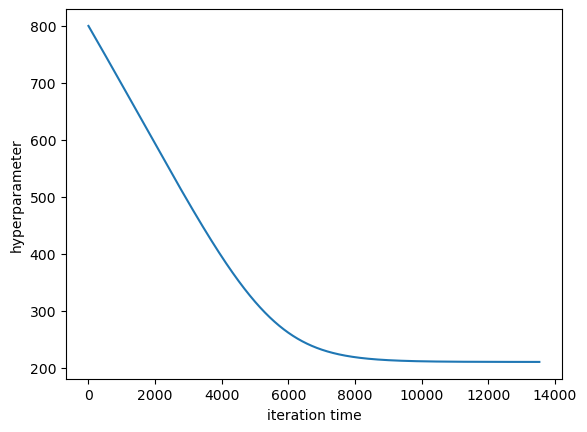

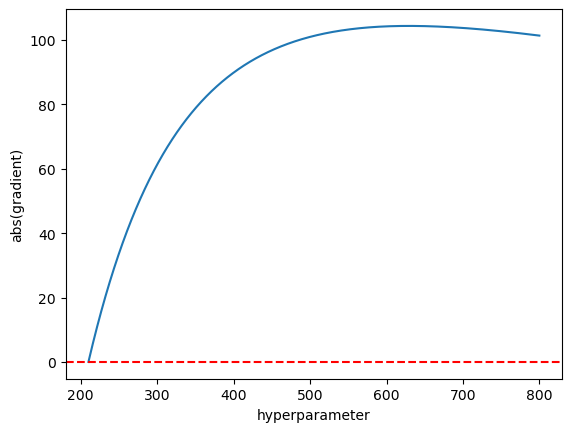

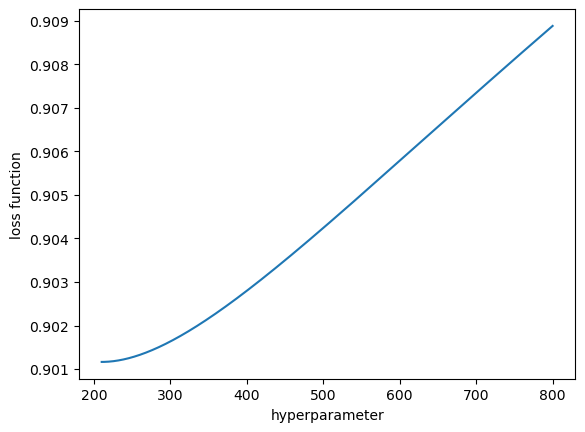

In [12]:
solve_problem()